In [72]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd
ds=xr.load_dataset("../results_stacked_hh_best_sample.nc")

Behaviour between samples and power biases for a given case

adjusting dataset with features and targets and scaling features

In [73]:
df=ds.to_dataframe().reset_index()
df['log_z0']=np.log(df['z0'].values)

features = df.drop(['wind_farm', 'flow_case','sample', 'case_index','model_bias_cap','k_b','ss_alpha',
                    'wind_direction','nt','turb_rated_power','pw_power_cap','ref_power_cap'], axis=1)
target = df['model_bias_cap']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)
y=target

In [74]:
features

,wind_speed,turbulence_intensity,potential_temperature,epsilon,k,lapse_rate,z0,LMO,ABL_height,capping_inversion_strength,capping_inversion_thickness,farm_density,Blockage_Ratio,Blocking_Distance,Farm_Length,Farm_Width,log_z0
0,9.946975,0.053803,293.157143,0.001880,0.429605,0.001008,0.002090,100000.0,951.166896,2.230581,274.327597,2.451599e+05,0.143910,1.000000,62.0,79.0,-6.170591
1,9.971009,0.069163,293.164520,0.003978,0.713338,0.001018,0.020800,100000.0,956.370264,2.196817,232.729528,2.451599e+05,0.112734,1.000000,58.0,76.0,-3.872802
2,9.952359,0.060814,293.160126,0.002704,0.549462,0.001015,0.006864,100000.0,952.575951,2.211540,253.596873,2.451599e+05,0.212993,1.000000,53.0,73.0,-4.981465
3,9.955688,0.057949,293.158852,0.002347,0.499248,0.001013,0.004365,100000.0,951.768487,2.218042,262.045921,2.451599e+05,0.058441,0.961863,49.0,69.0,-5.434137
4,9.950229,0.058088,293.158852,0.002360,0.501094,0.001013,0.004467,100000.0,951.787298,2.218861,262.590621,2.451599e+05,0.607518,0.604999,54.0,64.0,-5.411038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,12.965957,0.038599,293.156396,0.000678,0.375708,0.001146,0.000200,100000.0,1394.531458,2.285787,290.889510,1.633284e+06,0.898726,0.325955,45.0,45.0,-8.517193
178,12.981516,0.038991,293.156396,0.000686,0.384297,0.001128,0.000200,100000.0,2154.226023,2.283149,286.025116,1.633284e+06,0.898726,0.325955,45.0,45.0,-8.517193
179,12.983409,0.020000,293.305418,0.000616,0.101148,0.001126,0.000200,100000.0,298.759861,2.278333,297.013400,1.633284e+06,0.895262,0.328554,45.0,45.0,-8.517193
180,12.972423,0.027499,293.177894,0.000582,0.190891,0.001127,0.000200,100000.0,398.306920,2.281976,296.446248,1.633284e+06,0.898319,0.326261,45.0,45.0,-8.517193


demo of SIR vs PCA

https://joshloyal.github.io/sliced/auto_examples/plot_sir.html#sphx-glr-auto-examples-plot-sir-py 


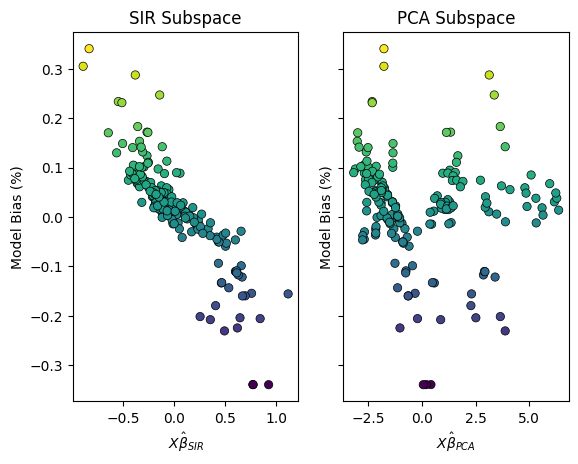

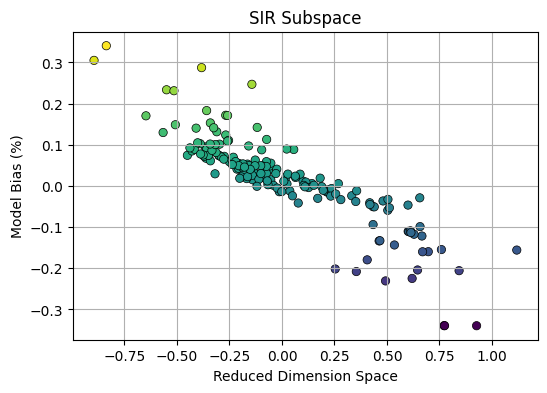

In [75]:
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

if not hasattr(np, 'int'):
    np.int = int
from sliced import SlicedInverseRegression


# fit SIR model
sir = SlicedInverseRegression().fit(X_scaled, y)
X_sir = sir.transform(X_scaled)

# fit PCA
pca = PCA(random_state=123).fit(X_scaled, y)
X_pca = pca.transform(X_scaled)


f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.scatter(X_sir[:, 0], y, c=y, cmap='viridis', linewidth=0.5, edgecolor='k')
ax1.set_title('SIR Subspace')
ax1.set_xlabel("$X\hat{\\beta}_{SIR}$")
ax1.set_ylabel("Model Bias (%)")

ax2.scatter(X_pca[:, 0], y, c=y, cmap='viridis', linewidth=0.5, edgecolor='k')
ax2.set_title('PCA Subspace')
ax2.set_xlabel("$X\hat{\\beta}_{PCA}$")
ax2.set_ylabel("Model Bias (%)")

plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(X_sir[:, 0], y, c=y, cmap='viridis', linewidth=0.5, edgecolor='k')
plt.title('SIR Subspace')
plt.xlabel("Reduced Dimension Space")
plt.ylabel("Model Bias (%)")
plt.grid()
plt.savefig("sir_subspace.png")


In [76]:
directions=sir.directions_
(directions**2).sum()

1.0000000000000002

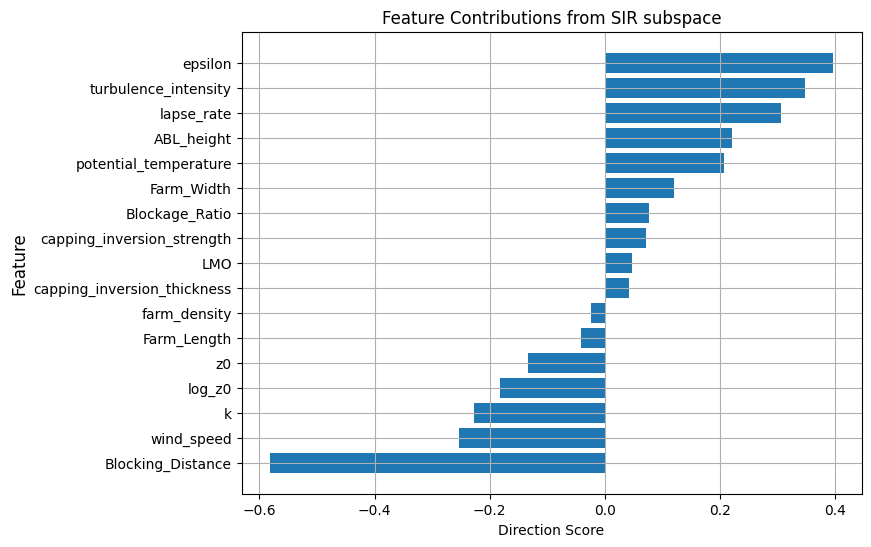

In [77]:
direction_scores = directions.flatten()

feature_names = features.columns.tolist()

feat_importance = pd.DataFrame({
    "Feature": feature_names,
    "Score": direction_scores
}).sort_values("Score", ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(feat_importance["Feature"], feat_importance["Score"])
plt.xlabel("Direction Score")
plt.ylabel("Feature", fontsize=12)
plt.title("Feature Contributions from SIR subspace")
plt.gca().invert_yaxis()  # highest score at top
plt.grid()
plt.show()
